# Part 1

Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee

import corner
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Upload the Excel Files containing Transit Fit Parameters

In [2]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')

Define a planetary system.

In [3]:
class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp,timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        #self.lld = lld # Linear LD coeff (Joey)
        #self.qld = qld # Quadratic LD coeff (Joey)  
        
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = u1 - u2
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        
        
        self.optimize1 = np.empty(0)
       
        #Part 2
        self.dfdt = np.empty(0)
        self.t0fit = np.empty(0)
        self.f0fit = np.empty(0)
        self.dfdtfit = np.empty(0)
        self.sigmafit = np.empty(0)
        
        self.t0fit_MCMC = np.empty(0) 
        self.f0fit_MCMC = np.empty(0) 
        self.dfdtfit_MCMC = np.empty(0) 
        self.sigmafit_MCMC = np.empty(0) 
          
    def Print(self):
        print("Star {}".format(self.name))

Number of targets that this code will analyze

In [4]:
num = 12

About "tr_window:" Array containing estimates for transit windows (in days). To find them, I initially used a transit window of 20 hours (very big) for all the targets and plotted the folded LC. After visually inspecting it, I made my guesses. Given that these are essentially transit_range*2 (and transit_range is already in days), I chose the transit windows to be twice the range of the transit (I also estimated the range visually, so this process is not perfect. However, it's enough for the code to work and yield good results).

In [5]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.07, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [6]:
targets = []
for i in range(0,num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    u1 = 0.0
    u2 = 0.0
    
    #lld = targetParams["LLD"][i] # Linear 
    #qld = targetParams["QLD"][i] # Quadratic
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']
    
    # Note: THE PARAMETERS BELOW ARE DIFFERENT (transwindow = 2*transrange)
    
    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

Use Kplr python routine to determine the LD coefficients based on Claret (2011)

In [8]:
import kplr
from kplr.ld import get_quad_coeffs

print "  *** Spectroscopic Properties of the Stars (Teff, Logg, FeH) *** "
print ""

for star in targets:
    print "Star", star.name, ":", star.teff, star.logg, star.feh

  *** Spectroscopic Properties of the Stars (Teff, Logg, FeH) *** 

Star 201516974 : 3963.619062 0.773705862 -0.600933643
Star 201920032 : 5767.687057 4.459656861 -0.034413524
Star 205924614 : 4435.275006 4.64 0.009365298
Star 205985357 : 5470.302233 4.547429431 -0.143620869
Star 206029314 : 5615.536476 4.555419802 -0.349781788
Star 206038483 : 5699.519396 4.453500331 0.022875892
Star 206061524 : 4322.21259 4.664210181 -0.13688303
Star 206082454 : 5708.114124 4.502768983 -0.2340741
Star 206155547 : 6198.552098 4.313442493 0.043631475
Star 206245553 : 5982.949047 4.3710788 -0.048406858
Star 206247743 : 5132.29918 4.562793716 0.008210117
Star 206311743 : 4927.387819 4.615674875 -0.158567487


Calculate Quadratic Limb Darkening Coefficients based on Spectroscopic Properties (Model: Claret 2011)

In [9]:
def quadraticLD(star): #Model: Claret 2011. 
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2

In [10]:
print "  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u1-u2)  *** "
print ""

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", mu1, mu2, mu1-mu2
    star.u1 = mu1
    star.u2 = mu2
    star.diffld = mu1-mu2

  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u1-u2)  *** 

Star 201516974 : 0.7867 -0.0114 0.7981
Star 201920032 : 0.4089 0.2556 0.1533
Star 205924614 : 0.678 0.0894 0.5886
Star 205985357 : 0.4415 0.2396 0.2019
Star 206029314 : 0.4906 0.1813 0.3093
Star 206038483 : 0.4089 0.2556 0.1533
Star 206061524 : 0.6656 0.0853 0.5803
Star 206082454 : 0.3858 0.2711 0.1147
Star 206155547 : 0.3277 0.2981 0.0296
Star 206245553 : 0.3643 0.2807 0.0836
Star 206247743 : 0.5362 0.1609 0.3753
Star 206311743 : 0.5508 0.1646 0.3862


Run the code

In [11]:
def processStar(star):
    
    goodP = intro(star)  
    mark_transits(star)
   
   # Plot Raw Light Curve 
    fig1 = plt.figure() 
    plt.title('Light Curve - Target ' + star.name, fontsize = 14) 
    plt.ylabel('Detrended Flux', fontsize = 14)
    plt.xlabel('Time  (JD)', fontsize = 14)
    plotLC(star.name, star.timeLC, star.fluxLC)
    plt.show() 
    
    transit_window(star, goodP)
    print "Nº of transits (theory):", len(star.transits), " at ", star.transits
    
    out_trans = out_transit(star)
    oot_fit(star)
    print "Nº of transits (observed):", len(star.transits)
    print "Standard deviation of the folded LC:", star.error_foldedLC
    
    # Plot the phase-folded light curve: star.dt vs. star.f_trans
    fig2 = plt.figure() 
    plotLC(star.name, star.dt, star.f_trans) 
    plt.title('Folded LC - Target ' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 14)
    plt.xlabel('Time from midtransit [days]', fontsize = 14)
    plt.show()
    
    # Plot color-coded transits
    fig3 = plt.figure()
    colTrans(star)

In [12]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

Identify transits in data

In [13]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -30
    maxepoch = 30
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits

In [14]:
def plotLC(name, time, flux):
    plt.plot(time,flux,'.')

In [15]:
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [16]:
def out_transit(star):
    print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

For each individual transit: perform a linear fit to the out-of-transit regions.

In [17]:
def oot_fit(star): 
    
    corFlux = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Correct Flux again (needed if we had to some star.transits didn't have data)
    
    corFlux2 = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    #Calculate the standard dev. of the folded LC 
    
    star.f_trans = corFlux2
    std_out = np.abs(star.dt) >= star.transRange
    err_folded = np.std(corFlux2[std_out])
    
    star.error_foldedLC = err_folded

Color-code odd/even transits

In [18]:
def colTrans(star):
    print "Color-coding of odd and even transits. They're shown in cyan and red, respectively."
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        
        if i % 2 == 0: #even transit
            plt.plot(star.dt[transitBool], star.f_trans[transitBool], '.', color = 'red', label = 'Even')
        else:
            plt.plot(star.dt[transitBool], star.f_trans[transitBool], '.', color = 'cyan', label = 'Odd')
   
    plt.title('Folded LC - EPIC' + star.name, fontsize = 14)
    plt.ylabel('Normalized Flux', fontsize = 12)
    plt.xlabel('Time from midtransit [days]', fontsize = 12)
    plt.show()

 --------- Star  201516974 ---------


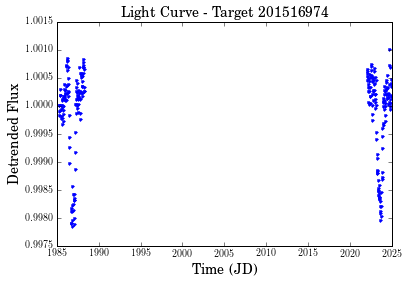

Nº of transits (theory): 2  at  [ 1986.80555162  2023.51544261]
Range of the transit (visual estimate): 0.4
Nº of transits (observed): 2
Standard deviation of the folded LC: 0.000219812380688


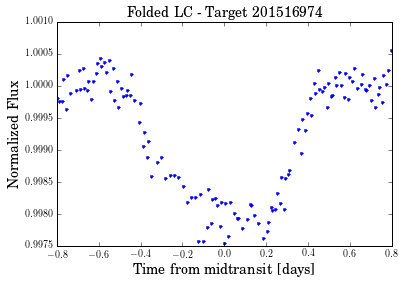

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


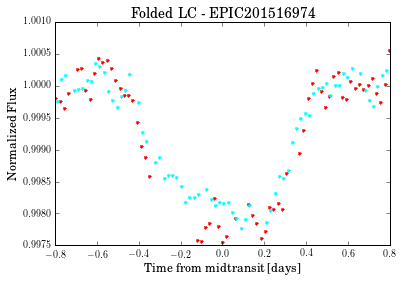

 --------- Star  201920032 ---------


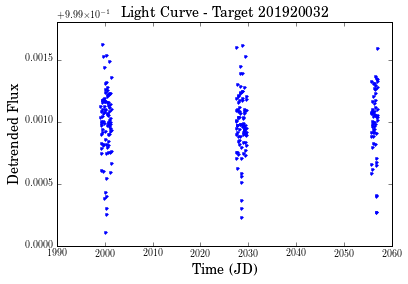

Nº of transits (theory): 3  at  [ 2000.205774    2028.47744553  2056.74911706]
Range of the transit (visual estimate): 0.18
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000165048310974


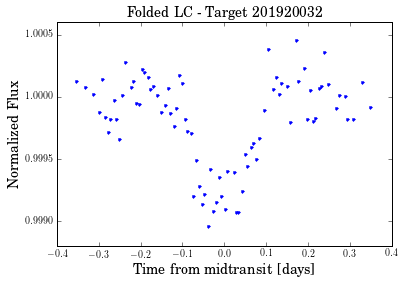

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


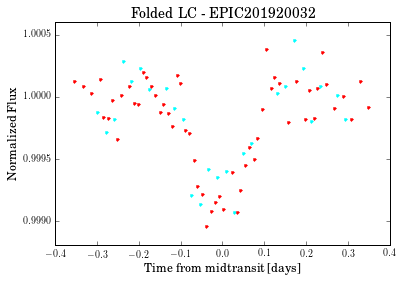

 --------- Star  205924614 ---------


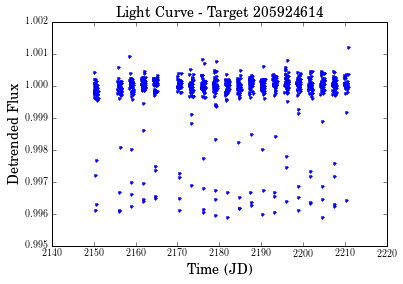

Nº of transits (theory): 22  at  [ 2150.424485    2153.27382604  2156.12316707  2158.97250811  2161.82184914
  2164.67119018  2167.52053121  2170.36987225  2173.21921328  2176.06855432
  2178.91789535  2181.76723639  2184.61657742  2187.46591846  2190.31525949
  2193.16460053  2196.01394156  2198.8632826   2201.71262363  2204.56196467
  2207.4113057   2210.26064674]
Range of the transit (visual estimate): 0.07
Nº of transits (observed): 20
Standard deviation of the folded LC: 0.000143836575041


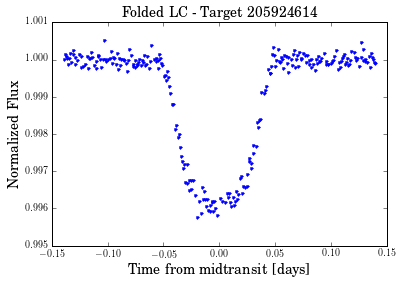

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


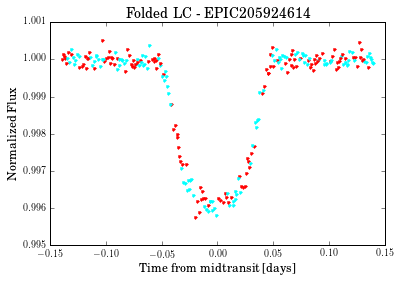

 --------- Star  205985357 ---------


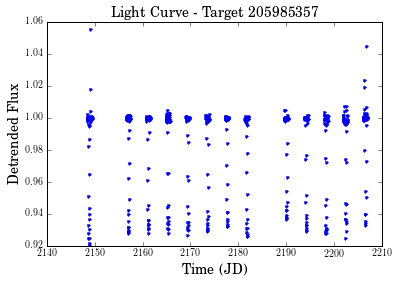

Nº of transits (theory): 15  at  [ 2148.728257    2152.85666526  2156.98507352  2161.11348177  2165.24189003
  2169.37029829  2173.49870655  2177.6271148   2181.75552306  2185.88393132
  2190.01233958  2194.14074784  2198.26915609  2202.39756435  2206.52597261]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 13
Standard deviation of the folded LC: 0.00551468343697


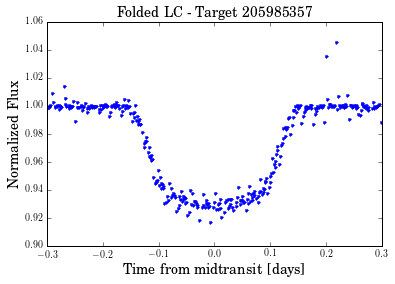

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


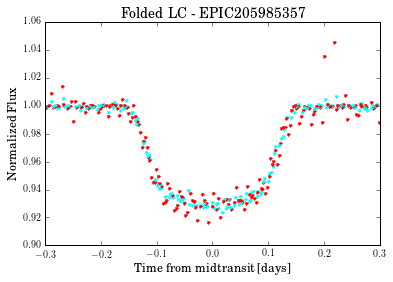

 --------- Star  206029314 ---------


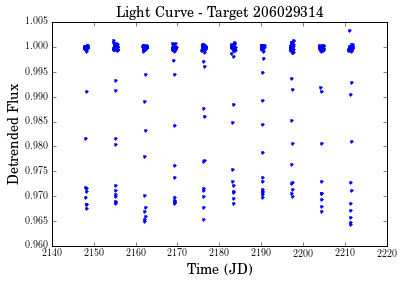

Nº of transits (theory): 10  at  [ 2148.06875     2155.09479332  2162.12083664  2169.14687996  2176.17292329
  2183.19896661  2190.22500993  2197.25105325  2204.27709657  2211.30313989]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 10
Standard deviation of the folded LC: 0.000338713882052


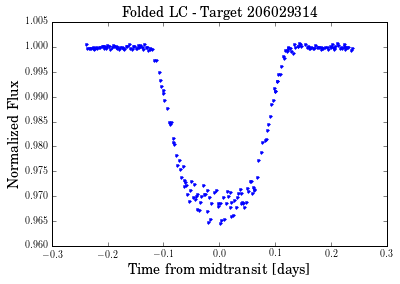

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


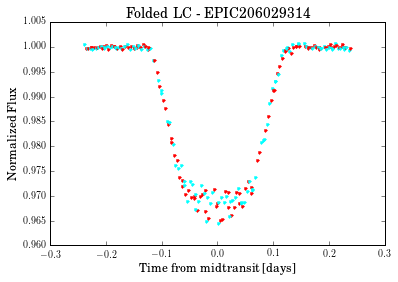

 --------- Star  206038483 ---------


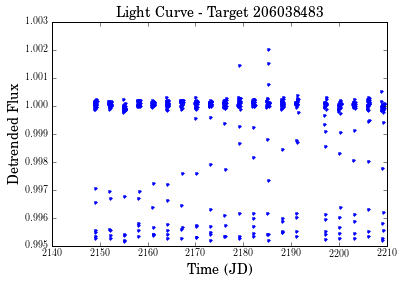

Nº of transits (theory): 21  at  [ 2149.05976     2152.06234098  2155.06492195  2158.06750293  2161.07008391
  2164.07266488  2167.07524586  2170.07782684  2173.08040781  2176.08298879
  2179.08556977  2182.08815074  2185.09073172  2188.09331269  2191.09589367
  2194.09847465  2197.10105562  2200.1036366   2203.10621758  2206.10879855
  2209.11137953]
Range of the transit (visual estimate): 0.07
Nº of transits (observed): 20
Standard deviation of the folded LC: 0.000193434445263


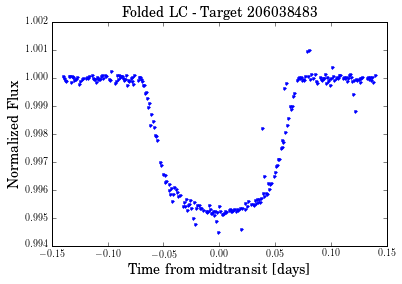

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


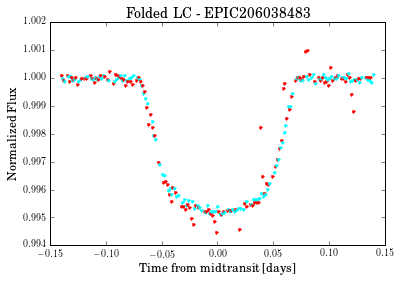

 --------- Star  206061524 ---------


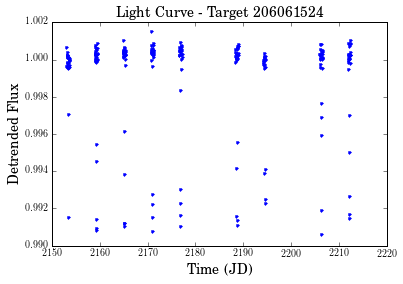

Nº of transits (theory): 11  at  [ 2153.323933    2159.20362989  2165.08332678  2170.96302367  2176.84272056
  2182.72241745  2188.60211433  2194.48181122  2200.36150811  2206.241205
  2212.12090189]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 9
Standard deviation of the folded LC: 0.000223955187886


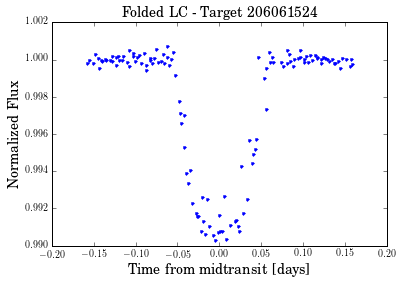

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


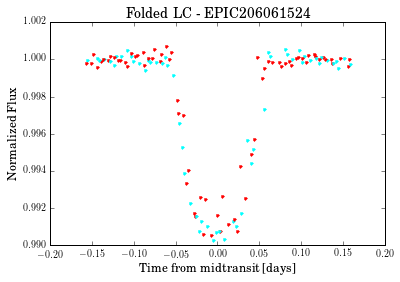

 --------- Star  206082454 ---------


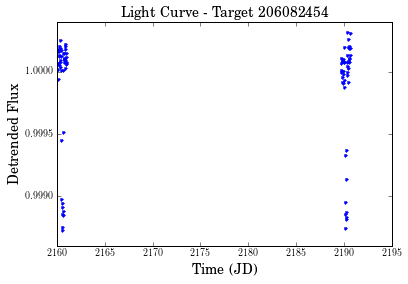

Nº of transits (theory): 2  at  [ 2160.54021572  2190.16619823]
Range of the transit (visual estimate): 0.12
Nº of transits (observed): 2
Standard deviation of the folded LC: 6.73039505317e-05


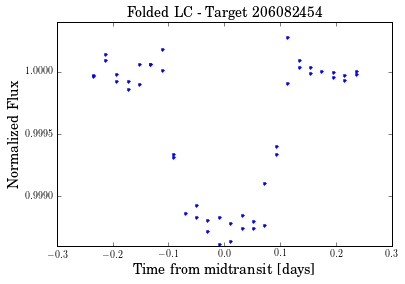

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


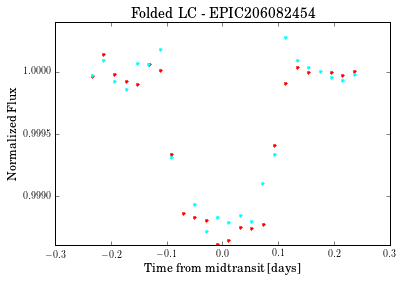

 --------- Star  206155547 ---------


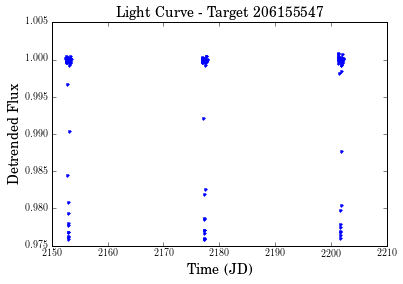

Nº of transits (theory): 3  at  [ 2152.884148    2177.27135138  2201.65855475]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 3
Standard deviation of the folded LC: 0.000244882412193


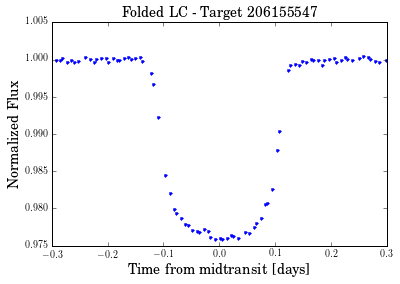

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


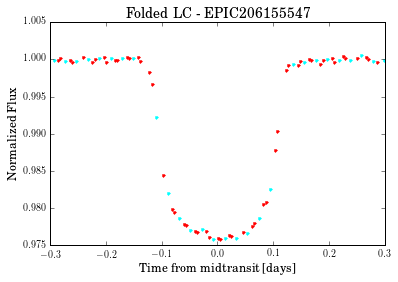

 --------- Star  206245553 ---------


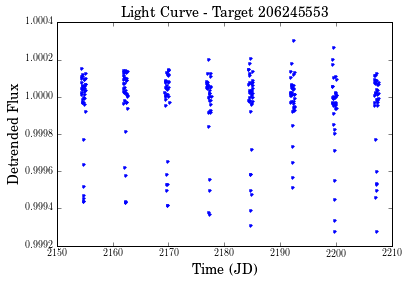

Nº of transits (theory): 8  at  [ 2154.672782    2162.16773498  2169.66268797  2177.15764095  2184.65259394
  2192.14754692  2199.64249991  2207.13745289]
Range of the transit (visual estimate): 0.08
Nº of transits (observed): 8
Standard deviation of the folded LC: 6.09692013114e-05


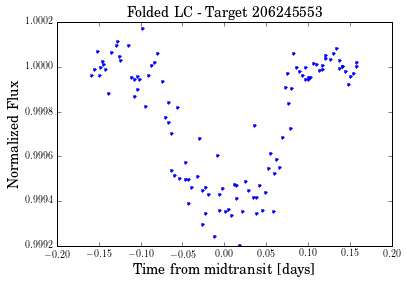

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


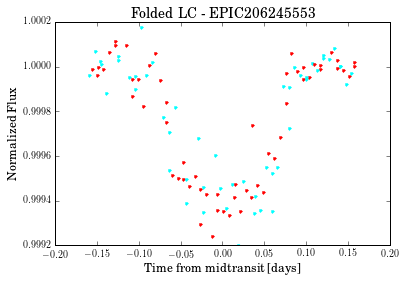

 --------- Star  206247743 ---------


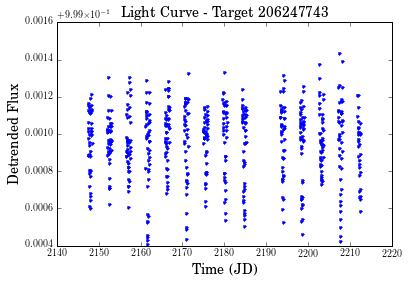

Nº of transits (theory): 15  at  [ 2147.821002    2152.42382923  2157.02665646  2161.6294837   2166.23231093
  2170.83513816  2175.43796539  2180.04079262  2184.64361985  2189.24644709
  2193.84927432  2198.45210155  2203.05492878  2207.65775601  2212.26058325]
Range of the transit (visual estimate): 0.18
Nº of transits (observed): 14
Standard deviation of the folded LC: 0.000108338756004


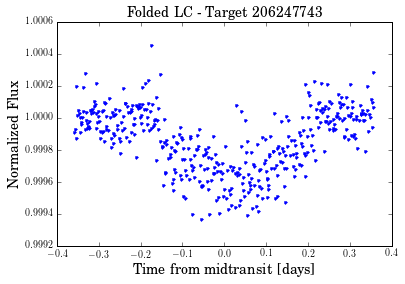

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


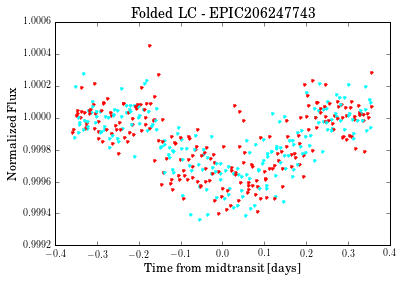

 --------- Star  206311743 ---------


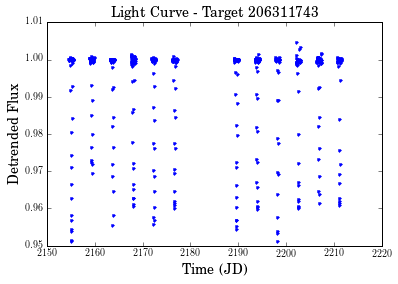

Nº of transits (theory): 14  at  [ 2155.041924    2159.35348755  2163.6650511   2167.97661465  2172.2881782
  2176.59974175  2180.9113053   2185.22286885  2189.5344324   2193.84599595
  2198.1575595   2202.46912305  2206.7806866   2211.09225015]
Range of the transit (visual estimate): 0.15
Nº of transits (observed): 12
Standard deviation of the folded LC: 0.000834467064107


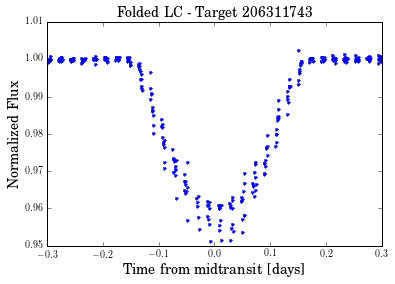

Color-coding of odd and even transits. They're shown in cyan and red, respectively.


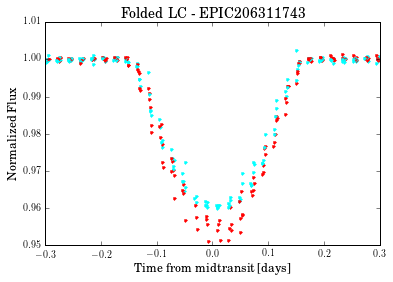

In [19]:
for star in targets:
    print " --------- Star ", star.name, "---------"
    processStar(star)

## Theoretical Model

Calculates the log of the likelihood of the transit model being the right model given the following parameters:

In [23]:
"""
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    
    
    Gaussian prior: We assume that the parameter we want to fit 
    is constrained within the range centered on the maximum value of a 
    Gaussian distribution. 
    
"""   

def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
 
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    
    ftheo = s.light_curve(timeLC, texp = tKep, tol=1e-08, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    # Chi Squared
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2)

def lnprior(theta): # This function ensures that our best estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    if (0.4 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (pmass > 0):
        return 0.0 
    
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [24]:
def opt(star, allfixed):
    nll = lambda *args: -lnprob(*args)

    # Minimization of the function "nll"
    result = op.minimize(nll, [1.2*star.depth, star.b, 0.0, 0.0, 0.6, star.mass, star.radius, 1.0], 
                             args = (star.dt, star.f_trans, star.error_foldedLC, allfixed),
                             options = {'disp': True}, 
                             method  ='Nelder-Mead')
    
    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

    star.optimize1 = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + star.diffld)
    u2_ml = sumLD_ml - u1_ml

    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.

    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))

    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = star.per, t0 = t0_ml, 
                            b = b_ml, e = star.ecc)

    s.add_body(body)
    t_theory = np.arange(-1.0, 1.0, tKep*0.01)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 5)
    f_theory = f_theory - 1.0 + f0_ml

    fig3 = plt.figure()
    plotLC(star.name, 24.0*star.dt, star.f_trans) #Plot folded LC (note: dt is now in hours)
    plotLC(star.name, 24.0*t_theory, f_theory)
    plt.title('Folded LC - Target ' + star.name, fontsize = 13)
    plt.xlabel('Time from midtransit [hours]', fontsize = 12)
    plt.ylabel('Relative Flux', fontsize = 12)
    plt.xlim([-star.transWindow*24.0, star.transWindow*24.0]) 
    plt.ylim([1-star.depth*1.6, star.depth*0.5+1]) 

    plt.show()

In [25]:
def results(star): #Print the best guesses & save them in a text file.
    print star.optimize1
    print "Standard dev. of the out-of-transit flux for the phase-folded light curve: ", star.error_foldedLC

    np.savetxt('1_'+star.name+'guesses.txt', (star.optimize1[0], star.optimize1[1], 
                                              star.optimize1[2], star.optimize1[3], 
                                              star.optimize1[4], star.optimize1[5], 
                                              star.optimize1[6], star.optimize1[7], 
                                              star.error_foldedLC), 
               fmt = '%.11f', delimiter='   ', header = """Best fit model parameters. These are: 
               Depth, Impact parameter, time of transit, sigma (additional white noise),
               Sum of LD coefficients,  Mass of the star, Radius of the star (gaussian priors
               on both), the out of eclipse flux, and the standard deviation of the 
               out-of-transit flux for the phase-folded light curve.""") 


Optimization for Star: 201516974


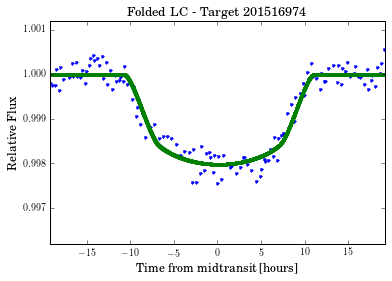

[  2.46410237e-03   8.71596890e-01   5.84888886e-03   7.73569467e-05
   7.24310113e-01   9.35722771e-03   1.29280834e+00   1.00001606e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000219812380688


Optimization for Star: 201920032
Optimization terminated successfully.
         Current function value: -680.747730
         Iterations: 277
         Function evaluations: 448


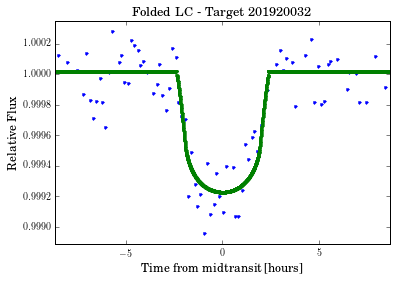

[  6.35473459e-04   1.63135098e-02  -3.14887699e-04   2.12645148e-08
   7.29809860e-01   9.91557524e-01   7.75104596e-01   1.00001867e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000165048310974


Optimization for Star: 205924614


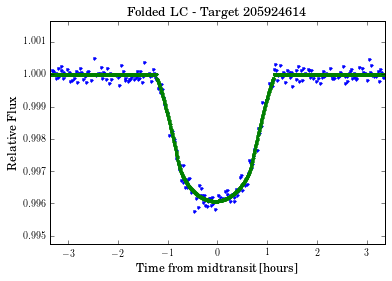

[  3.08403893e-03   1.95925950e-01  -2.14525265e-03   7.15817882e-05
   7.17008329e-01   7.05941373e-01   6.74964354e-01   1.00000033e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000143836575041


Optimization for Star: 205985357
Optimization terminated successfully.
         Current function value: -1604.500727
         Iterations: 1063
         Function evaluations: 1588


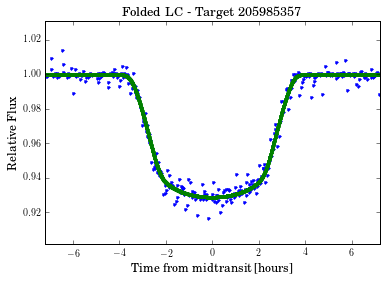

[  6.13201016e-02   2.49273396e-03  -1.19105159e-03   3.10831789e-04
   4.93754995e-01   3.21573506e-01   1.37111719e+00   9.99977871e-01]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.00551468343697


Optimization for Star: 206029314


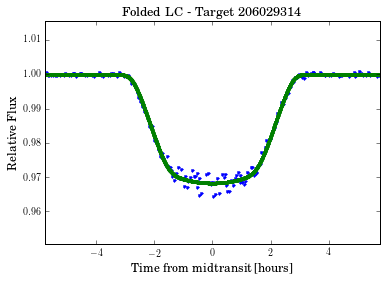

[  3.08637458e-02   6.82096054e-01  -4.20524808e-04   1.03057812e-03
   4.08004203e-01   5.59113523e-01   1.43622742e+00   1.00001376e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000338713882052


Optimization for Star: 206038483
Optimization terminated successfully.
         Current function value: -1955.719320
         Iterations: 971
         Function evaluations: 1463


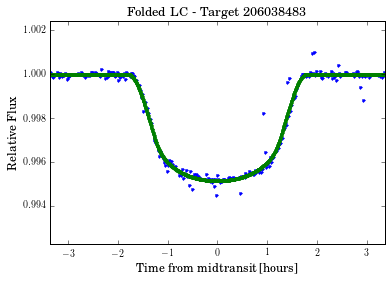

[  4.15669245e-03   5.23707521e-01  -2.03912535e-04   1.92728754e-04
   7.89346892e-01   9.81545611e-01   1.29442247e+00   1.00000657e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000193434445263


Optimization for Star: 206061524
Optimization terminated successfully.
         Current function value: -894.547682
         Iterations: 1053
         Function evaluations: 1535


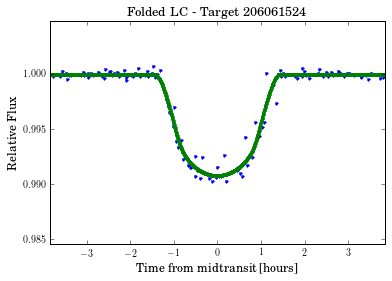

[  7.14566663e-03   3.31394142e-01  -4.48621996e-04   5.46275403e-04
   8.31622697e-01   6.45112149e-01   6.31461878e-01   9.99999127e-01]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000223955187886


Optimization for Star: 206082454
Optimization terminated successfully.
         Current function value: -406.809929
         Iterations: 840
         Function evaluations: 1244


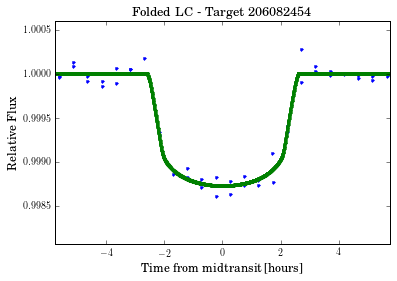

[  1.11652485e-03   3.91741839e-01  -1.99018864e-05   5.58962615e-05
   5.68242689e-01   8.98452522e-01   8.70786892e-01   1.00001466e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  6.73039505317e-05


Optimization for Star: 206155547


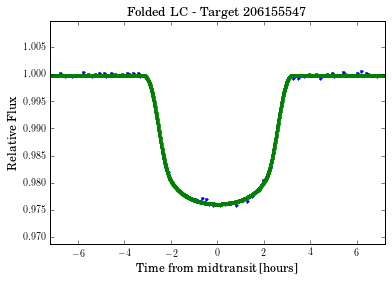

[  2.02134401e-02   2.57016129e-01   2.94961291e-04   1.81430604e-04
   6.48229488e-01   1.23274060e+00   1.11587107e+00   9.99963766e-01]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000244882412193


Optimization for Star: 206245553


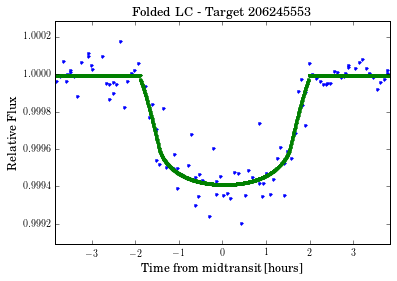

[  4.84704052e-04   2.30869410e-01   1.69254035e-03   5.95829917e-05
   7.12504856e-01   1.05595441e+00   1.01999788e+00   9.99998860e-01]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  6.09692013114e-05


Optimization for Star: 206247743
Optimization terminated successfully.
         Current function value: -3543.980367
         Iterations: 822
         Function evaluations: 1262


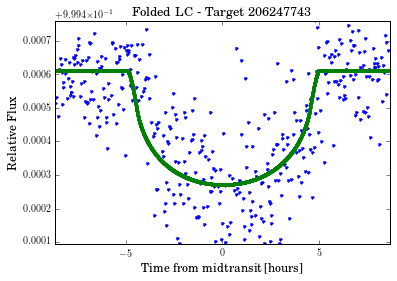

[  2.45039007e-04   3.44427964e-02   8.51953820e-04   7.37235433e-05
   9.98642263e-01   9.71415019e-01   3.04869511e+00   1.00001319e+00]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000108338756004


Optimization for Star: 206311743
Optimization terminated successfully.
         Current function value: -1462.502638
         Iterations: 1045
         Function evaluations: 1574


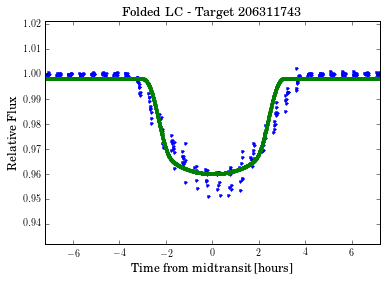

[  3.36161808e-02   1.95979235e-01   8.81057935e-04   4.78339208e-03
   4.00000002e-01   4.91302731e-01   1.31515052e+00   9.98598644e-01]
Standard dev. of the out-of-transit flux for the phase-folded light curve:  0.000834467064107



In [26]:
for star in targets:
    fixed = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep]
    print ""
    print "Optimization for Star:", star.name
    opt(star, fixed)
    results(star)
    print ""

# Part 2

Assume stellar flux changes over time.

In [24]:
def fluxchange(star):

    dfdt_ml = []
    guess = []
    
    for i in range (len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        k = np.polyfit(star.dt[outsideBool], star.f_trans[outsideBool], 1)
        dFdT = k[0]
        guess.append(dFdT)
    
    dfdt_ml = np.array(guess)   
    star.dfdt = dfdt_ml

In [25]:
def loadParams(parameters, star):
    
    depth_ml = parameters[0]
    b_ml = parameters[1]
    sumLD_ml = parameters[4]
    mass_ml = parameters[5] #Best guess for mass of the star
    radius_ml = parameters[6] #Best guess for radius of the star
    f0_ml = parameters[7] # Out-of-transit flux for the folded LC
    star.error_foldedLC = parameters[8] #error of out-of-transit flux

    allfix = [star.per, star.ecc, star.mass, star.mass_err, star.radius, star.radius_err, star.diffld, tKep, 
              depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml]
  
    return allfix

Calculates the log of the likelihood of the transit model being the right model using four free parameters: t0 (transit time), the flux outside of the transit, df/dt, and sigma (pt0_i, f0_i, dfdt_i, sigma_i). The index i represents the transit being analyzed. Note: theta[0] = pt0_i, theta[1]=f0_i, theta[2]=dfdt_i, theta[3]=sigma_i.

In [26]:
def lnlike2(theta, numTrans, timeLC, fluxLC, errorLC, allfixed):
    
    pt0_i, f0_i, dfdt_i, sigma_i = theta 
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml = allfixed 
    
    u1 = 0.5*(sumLD_ml+diffLD) 
    u2 = sumLD_ml-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = mass_ml, radius = radius_ml))
    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = period, t0 = pt0_i, b = np.abs(b_ml), e = ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma_i**2)
    
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)  
    ftheo = ftheo-1+f0_i+ dfdt_i*(timeLC-pt0_i) 
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))

def opt2 (star, transNum, timeLC, fluxLC, errorLC, allfixed, parameters): 
    
    n2 = lambda *args: -lnlike2(*args)
    
    # Note: args are given by function each trans.
    result = op.minimize(n2, [star.transits[transNum], parameters[7], star.dfdt[transNum], 
                              star.error_foldedLC], args = (transNum, timeLC, fluxLC, errorLC, allfixed), 
                         options={'disp': False}, method='Nelder-Mead')
                            
    t0_fit, f0_fit, dfdt_fit, sigma_fit = result["x"]
    return (t0_fit, f0_fit, dfdt_fit, sigma_fit)

For each transit in the LC of a star, find a best estimate for t0 (transit time), f0 (out-of-transit flux), dF/dT, and sigma. This function is called for every star.

Shows the fitting results obtained for each star in Part 1 and fits (in the background, with the "eachTrans" function, each individual transit)

In [27]:
def eachTrans(star, allfixed, parameters):
    
    corFlux = star.f_trans
    
    t0_fit = []
    f0_fit = []
    dfdt_fit = []
    sigma_fit = []
    
    for i in range(len(star.transits)):
        
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag==i)
        
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool])
               
        dt_i = star.dt[transitBool] # timeTrans-midTrans for transit i
        t_i = star.t_trans[transitBool] # timeTrans for transit i
        corFlux_i = corFlux[transitBool] #corrected flux for transit i.
  
        aux1, aux2, aux3, aux4 = opt2(star, i, t_i, corFlux_i, star.error_foldedLC, allfixed, parameters)
        
        t0_fit.append(aux1)
        f0_fit.append(aux2)
        """
        if aux3 < 0.001:
            aux3 = 0.0
         """
        dfdt_fit.append(aux3)
        sigma_fit.append(aux4)
    
    star.t0fit = t0_fit
    star.f0fit = f0_fit
    star.dfdtfit = dfdt_fit
    star.sigmafit = sigma_fit

In [28]:
print "-------------------------------- Fitting results from Part 1 --------------------------------"
print "       (1) Depth "
print "       (2) b  "
print "       (3) Sum of LD coeff"
print "       (4) Stellar mass "
print "       (5) Stellar radius"
print "       (6) Out-of-transit flux "
print "       (7) Error of the out-of-transit phase-folded light curve" 
print "                  " 

for star in targets:
    fluxchange(star)
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    allfixed = loadParams(parameters, star)
    print "Star", star.name,":"
    print parameters
    print "        "
    
    eachTrans(star, allfixed, parameters)

-------------------------------- Fitting results from Part 1 --------------------------------
       (1) Depth 
       (2) b  
       (3) Sum of LD coeff
       (4) Stellar mass 
       (5) Stellar radius
       (6) Out-of-transit flux 
       (7) Error of the out-of-transit phase-folded light curve
                  
Star 201516974 :
[  2.46410237e-03   8.71596890e-01   5.84888886e-03   7.73569500e-05
   7.24310113e-01   9.35722771e-03   1.29280834e+00   1.00001606e+00
   2.19812380e-04]
        
Star 201920032 :
[  6.35473460e-04   1.63135098e-02  -3.14887700e-04   2.12600000e-08
   7.29809860e-01   9.91557524e-01   7.75104596e-01   1.00001867e+00
   1.65048310e-04]
        
Star 205924614 :
[  3.08403893e-03   1.95925950e-01  -2.14525265e-03   7.15817900e-05
   7.17008329e-01   7.05941373e-01   6.74964354e-01   1.00000033e+00
   1.43836580e-04]
        
Star 205985357 :
[  6.13201016e-02   2.49273396e-03  -1.19105159e-03   3.10831790e-04
   4.93754995e-01   3.21573506e-01   1.371117

For every star, fit the individual transits of the light curve. Compute each transit LC integrated over a Kepler long cadence exposure time with the result derived from optimization. Then, plot it.

In [29]:
def plotOptim(star, parameters):
    
    plt.figure(1)
    if len(star.transits) <= 6:
        fig = plt.figure(figsize = (11,5))
    else:
        fig = plt.figure(figsize = (9, 52))    
   
    fig.suptitle('Individual Transit Fits for Star '+star.name, fontsize = 15)
             
    for i in range(len(star.transits)):
        
        s = transit.System(transit.Central(mu1 = star.u1, mu2 = star.u2, mass = parameters[5], radius = parameters[6]))
        body = transit.Body(r=np.sqrt(parameters[0])*parameters[6], period = star.per, 
                            t0 = star.t0fit[i], b = np.abs(parameters[1]), e = star.ecc)
        s.add_body(body)
 
        t_theory = np.arange(-1, 1, tKep*0.01) + star.t0fit[i]
        f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-08, maxdepth = 4)
        f_theory = (f_theory - 1.0 + star.f0fit[i]) + (star.dfdtfit[i]*(t_theory-star.t0fit[i]))
        
        
        ax = fig.add_subplot(len(star.transits), 1, i+1)
        ax.scatter(star.t_trans[star.flag == i], star.f_trans[star.flag == i])
        ax.plot(t_theory, f_theory)
        
        plt.xlim([min(star.t_trans[star.flag==i]), max(star.t_trans[star.flag == i])]) 
        plt.ylim([1-star.depth*1.5, star.depth*0.5+1])
   
        ax.set_xlabel('Hours', fontsize = 10)
        ax.set_ylabel('Relative flux', fontsize = 10)

    plt.show()

1 ) Star  201516974 has 2 transits. Fitting results:


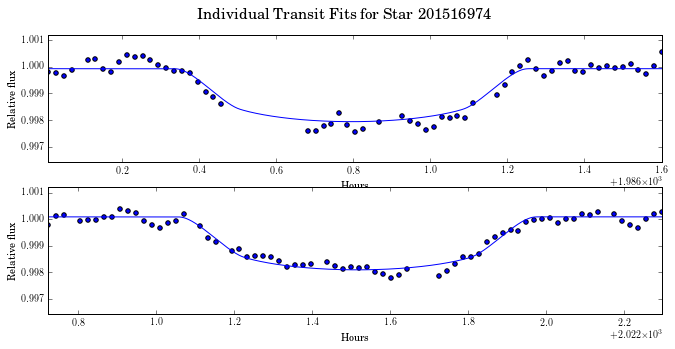

2 ) Star  201920032 has 3 transits. Fitting results:


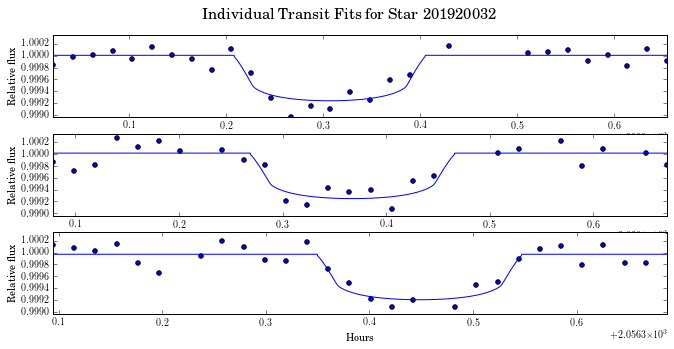

3 ) Star  205924614 has 20 transits. Fitting results:


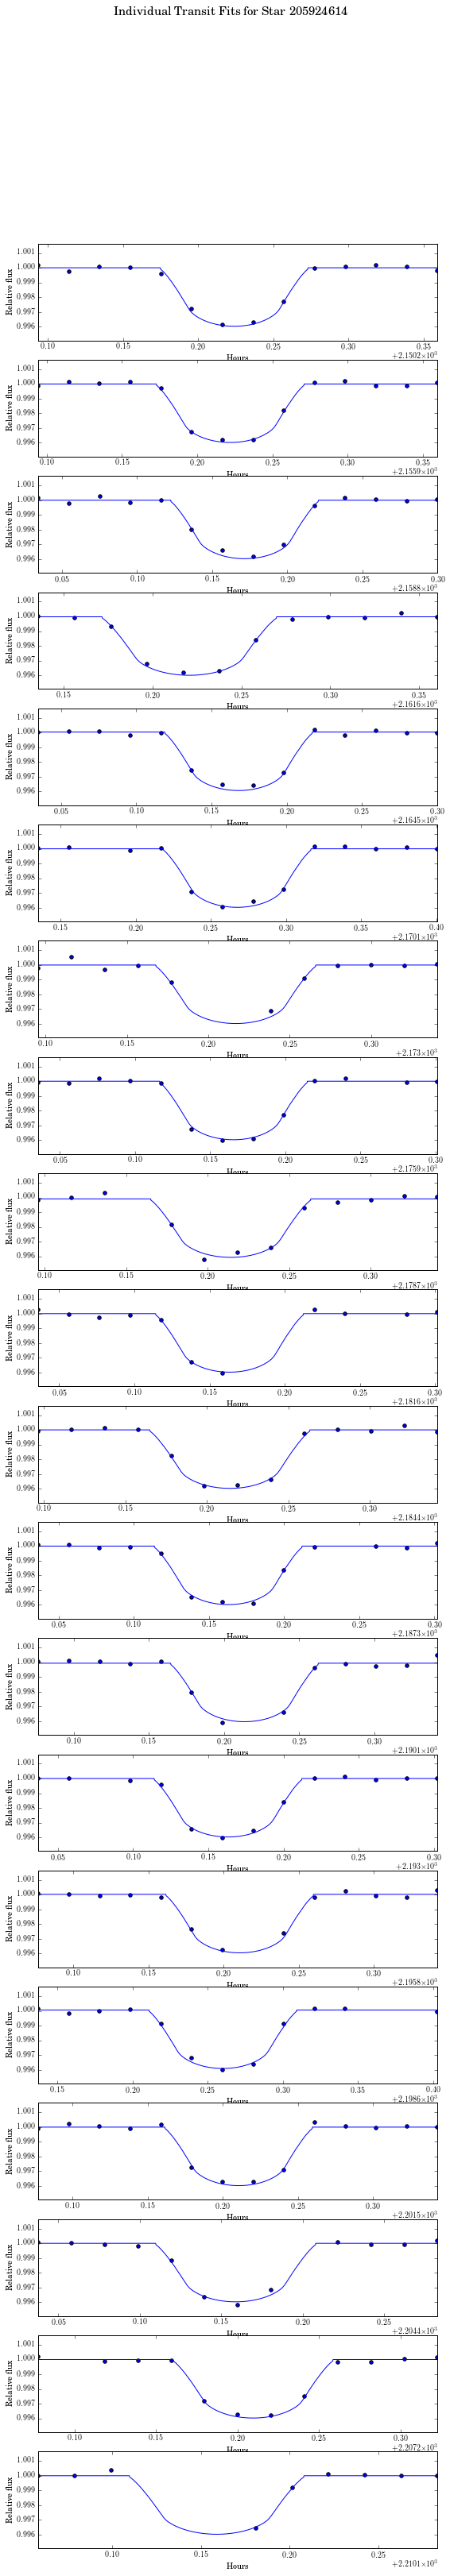

4 ) Star  205985357 has 13 transits. Fitting results:


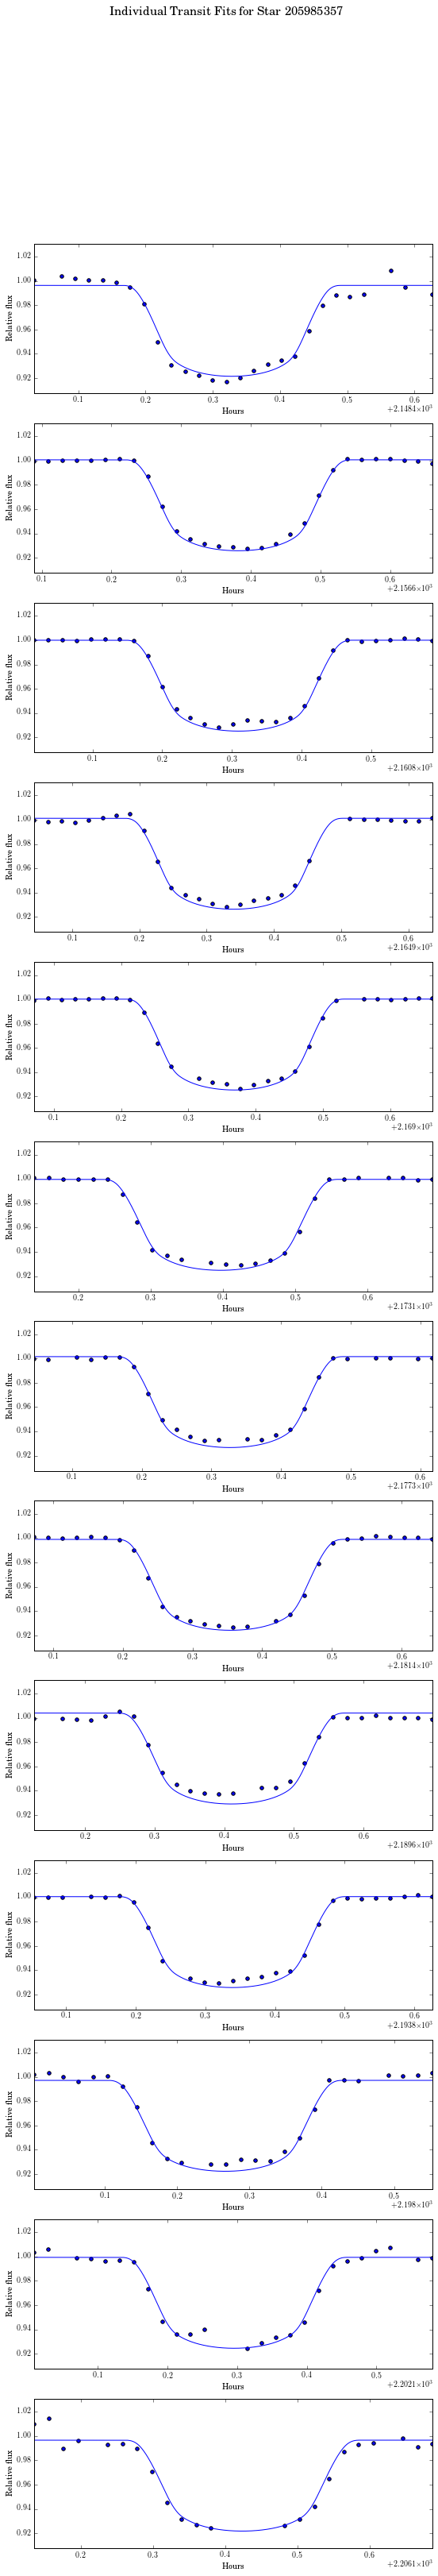

5 ) Star  206029314 has 10 transits. Fitting results:


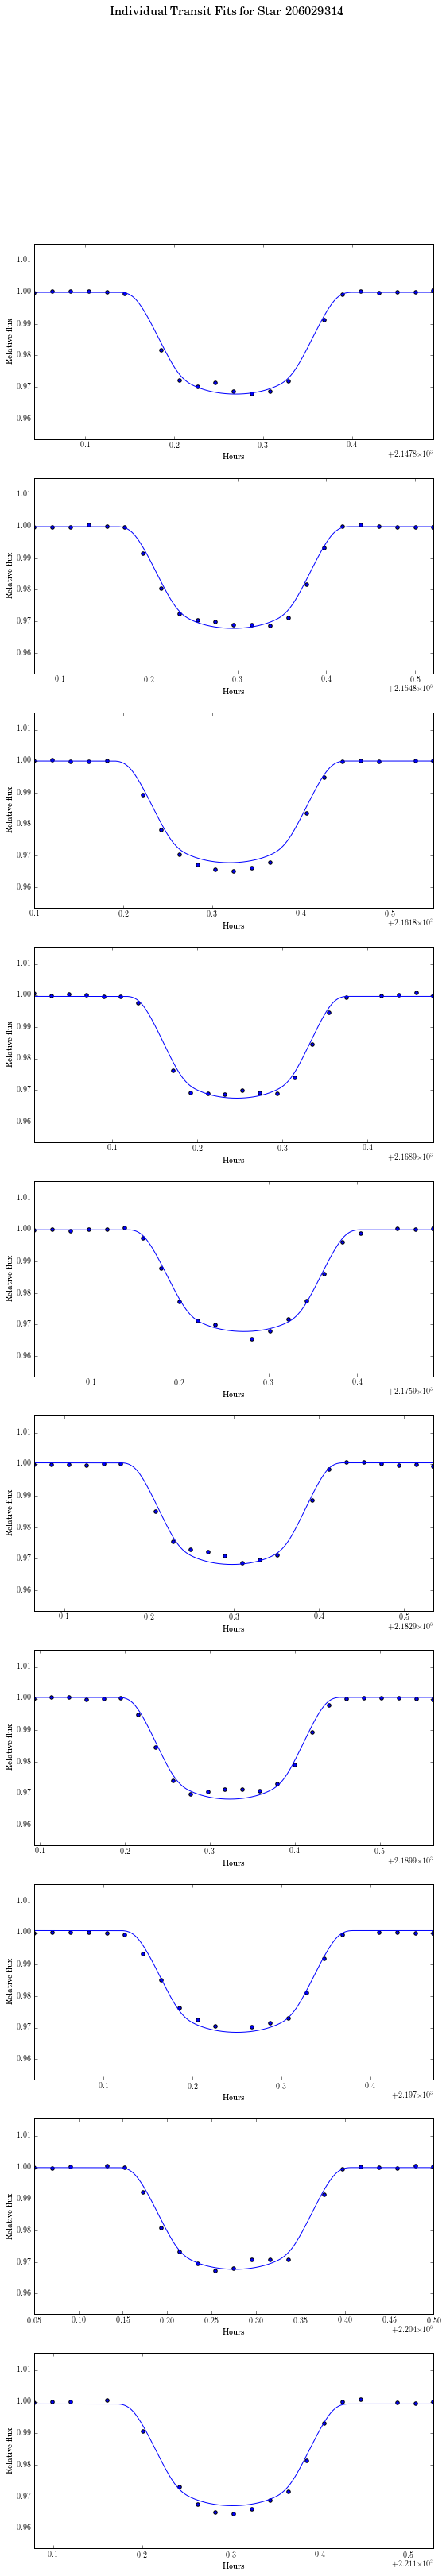

6 ) Star  206038483 has 20 transits. Fitting results:


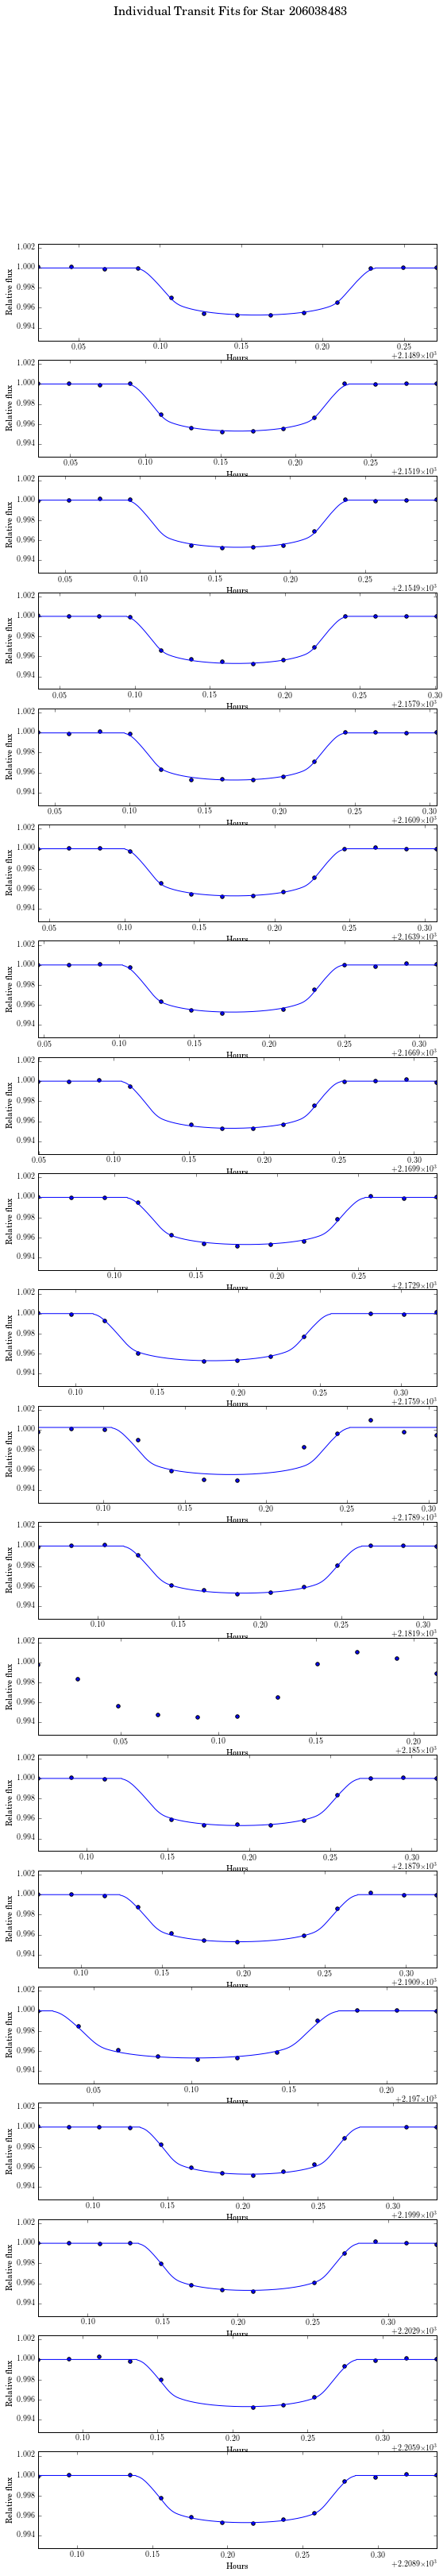

7 ) Star  206061524 has 9 transits. Fitting results:


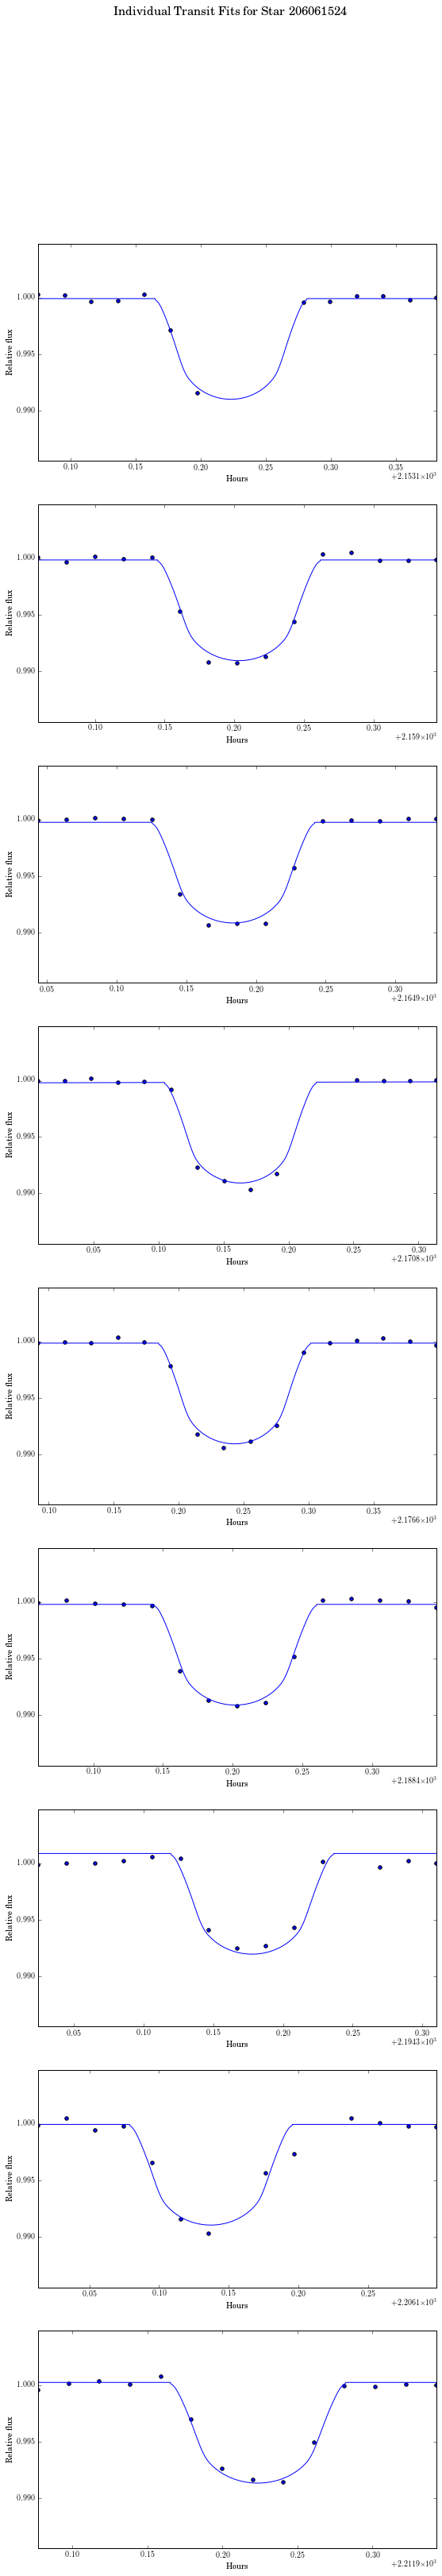

8 ) Star  206082454 has 2 transits. Fitting results:


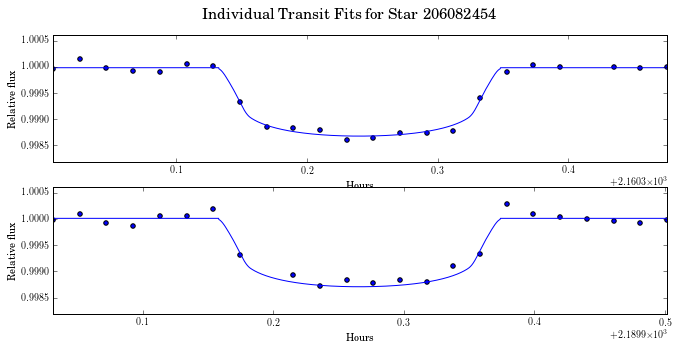

9 ) Star  206155547 has 3 transits. Fitting results:


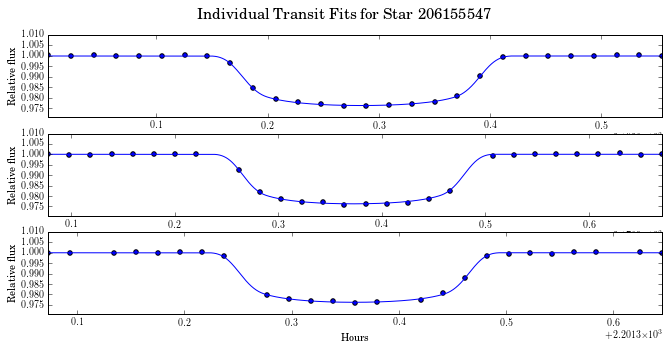

10 ) Star  206245553 has 8 transits. Fitting results:


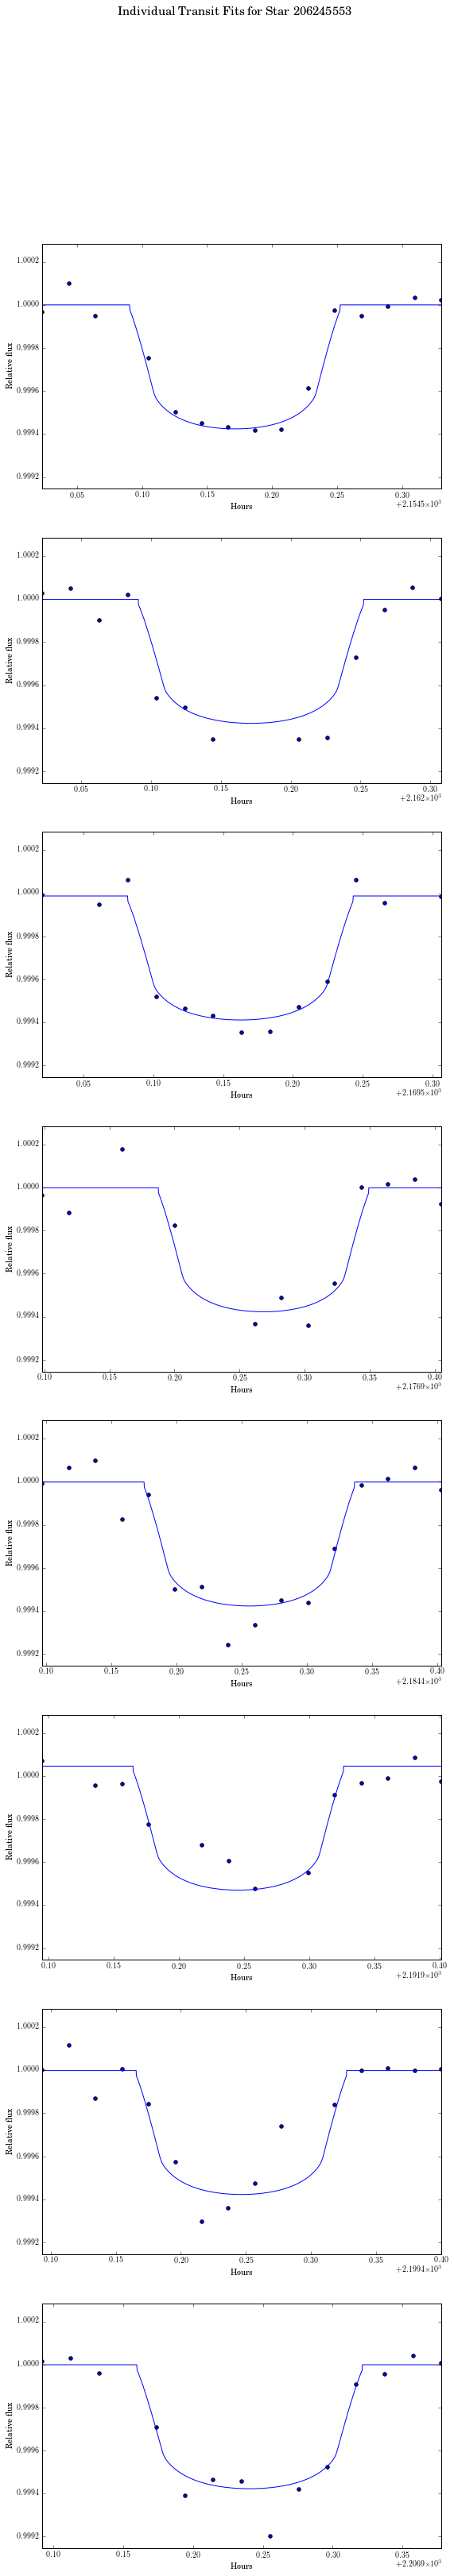

11 ) Star  206247743 has 14 transits. Fitting results:


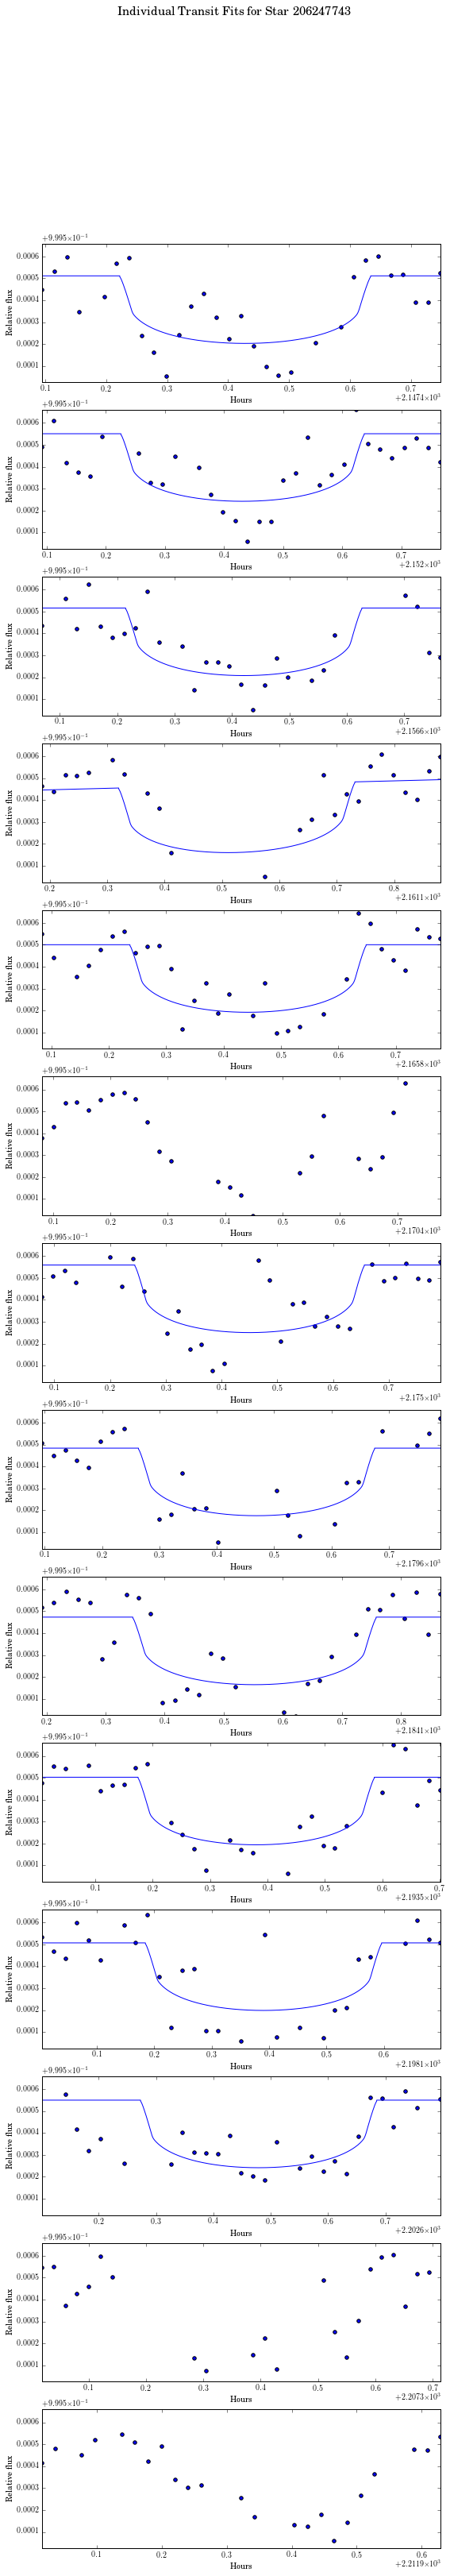

12 ) Star  206311743 has 12 transits. Fitting results:


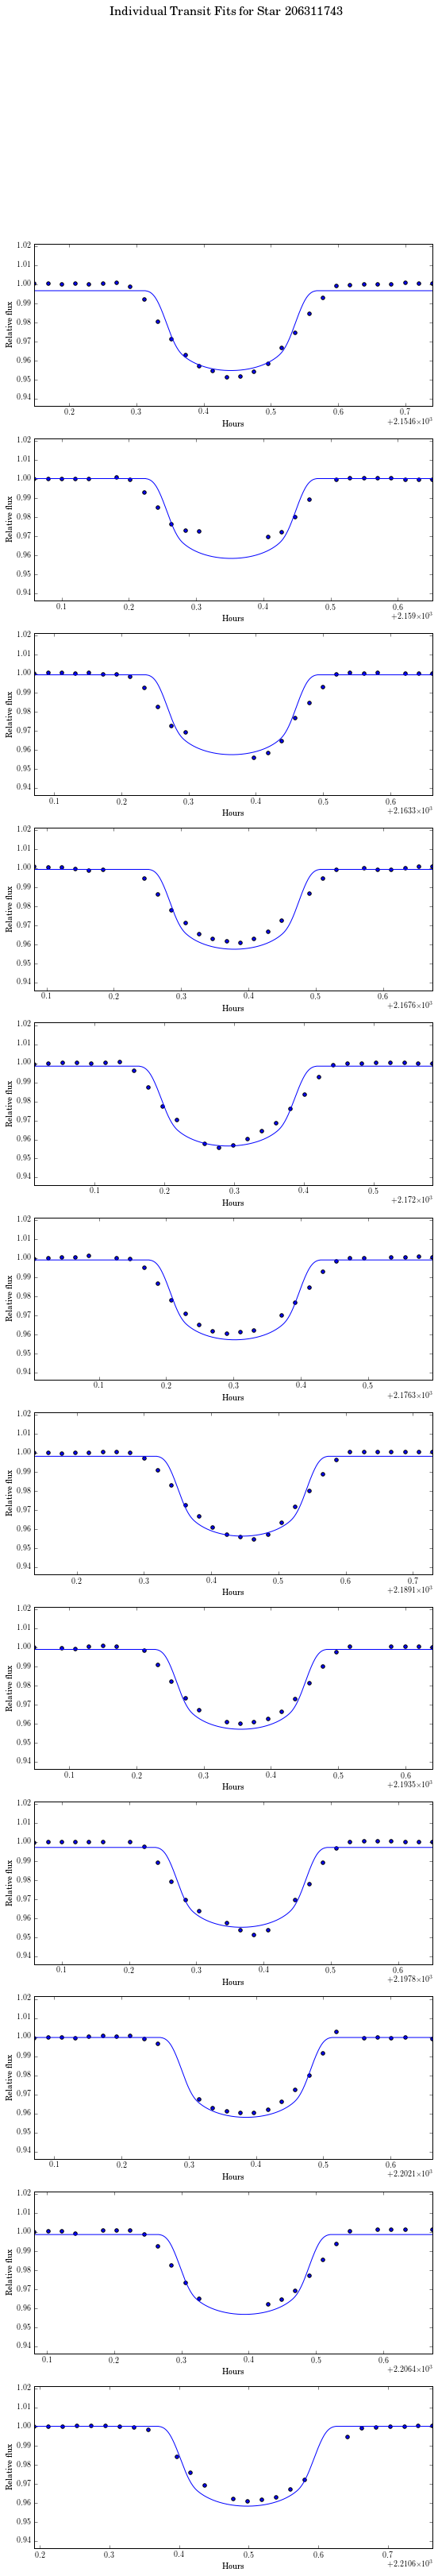

In [30]:
k = 1

for star in targets:
    params = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    print k, ") Star ", star.name, "has", len(star.transits), "transits. Fitting results:"
    plotOptim(star, params)
    k = k+1

Shows the best estimates for t0, f0, df/dt and sigma. 

In [31]:
print " ------        Optimally Fitted Model Parameters for the Individual Transit Fits        ------  "
print "        "

for star in targets:
    print " ***** Star ", star.name, ": ***** "
    print "       t0 estimates:", star.t0fit
    print ""
    print "       Out-of-Transit Flux:", star.f0fit
    print ""
    print "       dF/dT:", star.dfdtfit
    print ""
    print "       sigma:", star.sigmafit
    print "        "

 ------        Optimally Fitted Model Parameters for the Individual Transit Fits        ------  
        
 ***** Star  201516974 : ***** 
       t0 estimates: [1986.7949383836321, 2023.5159343317778]

       Out-of-Transit Flux: [0.99993394699366589, 1.000085016855778]

       dF/dT: [-1.5572100215975163e-14, -1.0279479988580125e-13]

       sigma: [8.7625042957772433e-05, -3.0449788835677718e-07]
        
 ***** Star  201920032 : ***** 
       t0 estimates: [2000.2067077053398, 2028.4673302991339, 2056.7482843020362]

       Out-of-Transit Flux: [1.0000075025245578, 1.0000186632495467, 0.99997335558322731]

       dF/dT: [-1.3989182509099331e-15, -1.5903234459527048e-14, 1.1354625082886391e-13]

       sigma: [3.0548244008236129e-06, 0.0001650447522618176, 5.672764784756993e-05]
        
 ***** Star  205924614 : ***** 
       t0 estimates: [2150.4240495230997, 2156.1220222023903, 2158.9715314802597, 2161.8206768820191, 2164.6680035695704, 2170.3675200051011, 2173.21690166288, 2176.065

## MCMC

Disregard false positives (according to VESPA) and (for now), the star 205985357, which has 3 transits that I haven't been able to fit. 

In [32]:
new_targets = np.empty(0)

for i in range(0, len(targets)):    
    if (targets[i].name != "205985357") and (targets[i].name != "206038483") and (targets[i].name != "206247743") and (targets[i].name != "206311743"):
        new_targets = np.append(new_targets, targets[i])
        
for star in new_targets:
    print "Star ", star.name

print len(new_targets)

#  205985357: False Positive
#  206038483: Missing 2 transits....
#  206247743: False Positive 
#  206311743: False Positive

Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206061524
Star  206082454
Star  206155547
Star  206245553
8


With the best fit solutions, we'll run an MCMC to estimate the uncertainties on the parameters.

In [34]:
import corner
for star in new_targets:
    
    print "****** Star ", star.name, "******"
    
    parameters = np.loadtxt('1_'+star.name+'guesses.txt', skiprows=1)
    print "Parameters:",  parameters
    print""
    allfixed = loadParams(parameters, star)
    print "All fixed:", allfixed
    
    
    ndim, nwalkers = 4, 100 # 4 imensions because we're fitting 4 parameters.
    steps = 2000

    t0fit_mcmc = np.zeros((len(star.transits), 3)) 
    f0fit_mcmc = np.zeros((len(star.transits), 3))
    dfdtfit_mcmc = np.zeros((len(star.transits), 3))
    sigmafit_mcmc = np.zeros((len(star.transits), 3))
    
    for i in range(0, len(star.transits)):
        
        """
        #https://github.com/dfm/emcee/blob/master/examples/quickstart.py
        """
        
        # Choose an initial set of positions for the walkers.
        #p0 = [np.random.rand(ndim) for j in xrange(nwalkers)]
        
        p0 = [[star.t0fit[i], star.f0fit[i], star.dfdtfit[i], star.sigmafit[i]]*(1+1e-5*np.random.randn(ndim)) for j in range(nwalkers)]
        
        # Initialize the sampler with the chosen specs.
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike2, 
                                        args = (i, star.t_trans[star.flag==i], 
                                                star.f_trans[star.flag==i], 0.1*star.error_foldedLC, allfixed))
        
        # Run 400 steps as a burn-in.
        pos, prob, state = sampler.run_mcmc(p0, 400)

        # Reset the chain to remove the burn-in samples.
        sampler.reset()
        
        # Starting from the final position in the burn-in chain, sample for 2000 steps.
        
        sampler.run_mcmc(pos, steps, rstate0 = state)

        # Burn again
        samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
        
        
        # Make corner plots. 
        figure = corner.corner(samples, labels = [r"$t0$", r"$f0$", "df/dt", r"$sigma$"],
                         quantiles = [0.16, 0.5, 0.84],
                         show_titles = True, title_args={"fontsize": 12})
        
        figure.gca().annotate("Transit %d" % (i+1), xy = (0.5, 1.0), xycoords="figure fraction",
                      xytext=(0, -5), textcoords="offset points",
                      ha = "center", va="top")
 
        v1 = np.percentile(samples[:,0], [15.84, 50, 84.16], axis=0)
        t0fit_mcmc[i,0] = v1[1] # 3rd value is the best estimate for t0 (it falls at the center)
        t0fit_mcmc[i,1] = v1[2] - v1[1] #+ Error of t0
        t0fit_mcmc[i,2] = v1[1] - v1[0] #- Error of t0

        v2 = np.percentile(samples[:,1], [15.84, 50, 84.16], axis=0)
        f0fit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for f0
        f0fit_mcmc[i,1] = v2[2]-v2[1] #+ Error of f0
        f0fit_mcmc[i,2] = v2[1]-v2[0] #- Error of f0

        v3 = np.percentile(samples[:,2],[15.84, 50, 84.16], axis=0)
        dfdtfit_mcmc[i,0] = v2[1] # 3rd value is the best estimate for df/dt
        dfdtfit_mcmc[i,1] = v2[2]-v2[1] #+ Error of df/dt
        dfdtfit_mcmc[i,2] = v2[1]-v2[0] #- Error of df/dt

        v4 = np.percentile(samples[:,3],[15.84, 50, 84.16], axis=0)
        sigmafit_mcmc[i,0] = v3[1] # 3rd value is the best estimate for sigma
        sigmafit_mcmc[i,1] = v3[2]-v3[1] #+ Error of sigma
        sigmafit_mcmc[i,2] = v3[1]-v3[0] #- Error of sigma
        
        plt.show()
        plt.savefig('2_'+star.name+'transit'+i+1)
    # Print the estimates for t0 (time of transit), f0 (flux outside the transit), sigma. The 2nd 
    # column gives the upper error and the 3rd, the lower error."""
    
    star.t0fit_MCMC = t0fit_mcmc 
    star.f0fit_MCMC = f0fit_mcmc
    star.dfdtfit_MCMC = dfdtfit_mcmc
    star.sigmafit_MCMC = sigmafit_mcmc  
    
    print "MCMC for t0: ",  star.t0fit_MCMC
    print "MCMC for dfdt: ", star.dfdtfit_MCMC
    print "MCMC for f0: ", star.f0fit_MCMC
    print "MCMC for sigma:  ", star.sigmafit_MCMC
    
    np.savetxt('2_'+star.name+'t0_mcmc.txt', star.t0fit_MCMC, fmt = "%.8f" , delimiter='   ', header = """MCMC results: t0 (Transit times)""")
    np.savetxt('2_'+star.name+'f0_mcmc.txt', star.f0fit_MCMC, fmt = "%.8f" , delimiter='   ', header = """MCMC results: f0 (out-of-transit flux for each transit)""")

****** Star  201516974 ******
Parameters: [  2.46410237e-03   8.71596890e-01   5.84888886e-03   7.73569500e-05
   7.24310113e-01   9.35722771e-03   1.29280834e+00   1.00001606e+00
   2.19812380e-04]

All fixed: [36.709890984200001, 0.0, 0.7, 0.29999999999999999, 1.5, 0.29999999999999999, 0.7980999999999999, 0.020430555555555556, 0.00246410237, 0.87159688955000003, 0.72431011337999995, 0.0093572277100000007, 1.2928083399000001]
emcee: Exception while calling your likelihood function:
  params: [  1.98677292e+03   9.99917389e-01  -1.55717932e-14   8.76238678e-05]
  args: (0, array([ 1986.007522,  1986.027954,  1986.048386,  1986.068818,
        1986.109682,  1986.130114,  1986.150546,  1986.170979,
        1986.191411,  1986.211843,  1986.232275,  1986.252707,
        1986.273139,  1986.293571,  1986.314003,  1986.334435,
        1986.354867,  1986.375299,  1986.395732,  1986.416164,
        1986.436596,  1986.457028,  1986.681781,  1986.702213,
        1986.722645,  1986.743077,  1986.7

Traceback (most recent call last):
  File "/Users/mbadenas/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-26-6a6ee47150d6>", line 15, in lnlike2
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
  File "/Users/mbadenas/anaconda/lib/python2.7/site-packages/transit/transit.py", line 424, in light_curve
    np.radians(iy), texp, tol, maxdepth)
KeyboardInterrupt


KeyboardInterrupt: 